nodes.shape=(2, 7, 7, 2)


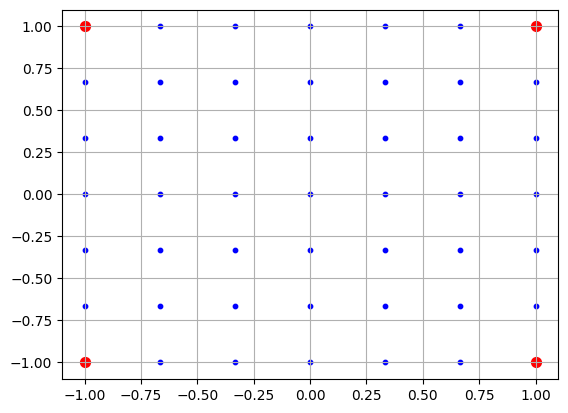

In [1]:
from matplotlib import pyplot as plt
from pprint import pp
import numpy as np

import cProfile, pstats, io
from pstats import SortKey
pr = cProfile.Profile()
pr.enable()

# Chose number of robots
k = 2
# Chose recharging proportionality constant
q_k = 0.1  # This means that each robot will need to charge for 10 minutes for every 100 minutes travelled
# Chose the number of nodes in an axis
n = 7
# Create a uniform (n, n, 2) numpy grid for MAXIMUM SPEED
nodes = np.mgrid[-1:1:n * 1j, -1.:1:n * 1j]
nodes = nodes.reshape(nodes.shape + (1,))
nodes = np.concatenate((nodes[0], nodes[1]), axis=2)
nodes = nodes.reshape((1,) + nodes.shape)
nodes = np.concatenate([nodes for _ in range(k)], axis=0)
print(f"{nodes.shape=}")

# nodes = targets + depots
# Note: If a node isn't a depot, it is a target

# Specify depots
## One depot node
# depots_i = np.array([[0, 0]])
## Four depot nodes (one in each corner)
depot_indices = np.array([[0, 0], [0, n-1], [n-1, 0], [n-1,n-1]])
# print(f"{depot_indices=}")
target_indices = []
for i in range(n):
    for j in range(n):
        is_depot = False
        for depot in depot_indices:
            if i == depot[0] and j == depot[1]:
                is_depot = True
                continue
        if not is_depot:
            target_indices.append([i,j])
target_indices = np.array(target_indices)
# print(f"{target_indices=}")

# Chose starting depot node
B_k = depot_indices
# print(f"{B_k=}")

# Graphical sanity check
plt.figure()
plt.scatter(nodes[0,:,:,0], nodes[0,:,:,1], c='blue', s=10)
plt.scatter(nodes[0,depot_indices[:,0],depot_indices[:,1],0], nodes[0,depot_indices[:,0],depot_indices[:,1], 1], c='red', s=50)
plt.grid()
plt.show()


In [2]:
import itertools

# Calculate c_{i1,j1,i2,j2} (c[i1, j1, i2, j2] is the cost (including recharging, q_k) from TARGET and DEPOT nodes (i1, j1) to (i2, j2))
cost = np.zeros((n,n,n,n))
for i1, j1, i2, j2 in itertools.product(range(n), range(n), range(n), range(n)):
    cost[i1,j1,i2,j2] = np.sqrt((nodes[0,i1,j1,0]-nodes[0,i2,j2,0]) ** 2 + (nodes[0,i1,j1,1]-nodes[0,i2,j2,1]) ** 2)
    # print(f"({i1},{j1},{i2},{j2}):({targets[i1,j1,0]},{targets[i1,j1,1]},{targets[i2,j2,0]},{targets[i2,j2,1]}): {target_cost[i1,j1,i2,j2]}")
print(f"{cost.shape=}")


cost.shape=(7, 7, 7, 7)


In [3]:
import gurobipy as gp
from gurobipy import GRB

m = gp.Model()
x = m.addMVar((k,n,n,n,n), name='x', vtype=GRB.INTEGER, lb=0, ub=len(target_indices))
p = m.addMVar((k,n,n,n,n), name='p', vtype=GRB.INTEGER, lb=0, ub=len(target_indices))
#if(n%2 == 0):
#    L = n  # Fuel capacity (1 unit of fuel = 1 unit of distance)
#else:
#    L = n - 1
L = 2*np.sqrt((n/2)*(n/2)+(n/2)*(n/2)) #=4.94
#=
#It is assumed that for each target point, there is a depot that is reachable by expending at most L/2 of the fuel.
M = L + np.sqrt(n*n+n*n)  # √8 is the max possible distance between our nodes (-1, -1) and (1, 1)
r = m.addMVar((k,n,n), name='r', vtype=GRB.CONTINUOUS, lb=0, ub=L) # (20)
p_max = m.addVar(vtype=GRB.CONTINUOUS, name="p_max")

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2421626
Academic license - for non-commercial use only - registered to cecummings@wpi.edu


In [4]:
# A. Integer Constraints (4), (5)
for i1, j1, i2, j2 in itertools.product(range(n), range(n), range(n), range(n)):
    are_both_depot = False
    for d1 in depot_indices:
        if d1[0] != i1 or d1[1] != j1 : continue
        for d2 in depot_indices:
            if d2[0] != i2 or d2[1] != j2: continue
            are_both_depot = True
    if not are_both_depot:
        for ki in range(k):
            _ = m.addConstr(x[ki,i1,j1,i2,j2] <= 1)

In [5]:
# B. Degree Constraints (6), (7), (8), (9), (10)
# (6) and (7) Only one robot arrives to and leaves from a target (B_k is a depot, so we don't need to remove it from targets)
_ = m.addConstrs(x[:,i1,j1,:,:].sum() == 1 for i1, j1 in target_indices)
_ = m.addConstrs(x[:,:,:,i1,j1].sum() == 1 for i1, j1 in target_indices)

# (8) and (9) Begin and end at same position B_k
_ = m.addConstrs(x[ki,B_k[ki,0],B_k[ki,1],:,:].sum() <= 1 for ki in range(k))
_ = m.addConstrs(x[ki,:,:,B_k[ki,0],B_k[ki,1]].sum() <= 1 for ki in range(k))
# (10) Every robot that visits a target leaves the target
_ = m.addConstrs((x[ki,:,:,i1,j1]-x[ki,i1,j1,:,:]).sum() == 0 for ki in range(k) for i1 in range(n) for j1 in range(n))

# Additional constraint: no loopholes!
# _ = m.addConstrs(x[ki, i, j, i, j] == 0 for ki in range(k) for i in range(n) for j in range(n))

In [6]:
# C. Capacity and Flow Constraints (11), (12), (13), (14)

# (11) and (12) flow constraints
for ki in range(k):
    right_side = 0
    for i1, j1 in target_indices:
        for i2, j2 in itertools.product(range(n), range(n)):
            right_side += x[ki,i1,j1,i2,j2]
    _ = m.addConstr((p[ki,B_k[ki,0],B_k[ki,1],:,:] - p[ki,:,:,B_k[ki,0],B_k[ki,1]]).sum() == right_side)
_ = m.addConstrs((p[ki,:,:,i1,j1] - p[ki,i1,j1,:,:]).sum() == x[ki,i1,j1,:,:].sum() for ki in range(k) for i1, j1 in target_indices)

# (13) Make sure target capacity doesn't change when passing through a depot
for ki in range(k):
    for i, (i1, j1) in enumerate(depot_indices):
        if i == ki: continue  # Why? See: https://github.com/NESTLab/mrpcp#linear-constraints
        left_side = 0
        for i2, j2 in itertools.product(range(n), range(n)):
            left_side += p[ki,i2,j2,i1,j1] - p[ki,i1,j1,i2,j2]
        _ = m.addConstr(left_side == 0)

# (14) Ensure that target capacity for each robot doesn't exceed |T|
_ = m.addConstrs(p[ki,i1,j1,i2,j2] <= len(target_indices) * x[ki,i1,j1,i2,j2] for ki in range(k) for i1 in range(n) for j1 in range(n) for i2 in range(n) for j2 in range(n))


In [7]:
"""
# Fuel Constraints (15), (16), (17), (18), (19), (20)
# This includes adding another decision variable
from queue import PriorityQueue
import math
import itertools
#https://www.redblobgames.com/pathfinding/a-star/implementation.html#python-astar
def neighbors(curr):
    ns = [(curr[0]+1, curr[1]), (curr[0]-1, curr[1]), (curr[0], curr[1]+1), (curr[0], curr[1]-1), (curr[0]+1, curr[1]+1), (curr[0]-1, curr[1]-1), (curr[0]+1, curr[1]-1), (curr[0]-1, curr[1]+1)]
    neighbors = []
    for n in ns:
        if n[0] <= 9 and n[0] >= 0 and n[1] <= 9 and n[1] >= 0:    
            neighbors.append(n)
    return neighbors

#there are absolutely better ways to do this, this is just the one that took me 10 minutes to do.
def a_star_search(i1, j1, i2, j2):
    frontier = PriorityQueue()
    frontier.put((i1,j1), 0)
    came_from = dict()
    cost_so_far = dict()
    came_from[(i1,j1)] = None
    cost_so_far[(i1,j1)] = 0
    
    
    while not frontier.empty():
        current = frontier.get()
        if current == (i2, j2):
            break

        for next in neighbors(current):
            new_cost = cost_so_far[current] + math.dist(current, next)
            if next not in cost_so_far or new_cost < cost_so_far[next]:
                cost_so_far[next] = new_cost
                priority = new_cost #+ math.dist(next, (i2,j2))
                frontier.put(next, priority)
                came_from[next] = current
                
    curr_val = (i2, j2)
    final_path = []
    while curr_val != (i1, j1):
        final_path.append(curr_val)
        curr_val = came_from[curr_val]
            
    final_path.append((i1, j1))
    final_path.reverse()
    
    return final_path
# Fuel Constraints (15), (16), (17), (18), (19), (20)
# This includes adding another decision variable
r = m.addMVar((k,n,n), name='r', vtype=GRB.INTEGER, lb=0, ub=fuel_capacity)  # (20)


for i1, j1, i2, j2 in itertools.product(range(n), range(n), range(n), range(n)):
    fij = len(a_star_search(i1,j1,i2,j2))
    _ = m.addConstr(r[ki,i2,j2]-r[ki,i1,j1]+fij <= (fuel_capacity+max_fuel_expenditure)*(1-x[ki,i1,j1,i2,j2])) #(15)
    _ = m.addConstr(r[ki,i2,j2]-r[ki,i1,j1]+fij >= -(fuel_capacity+max_fuel_expenditure)*(1-x[ki,i1,j1,i2,j2])) #(16)

    #(20)
    for depot in depots_i:
        if i1 == depot[0] and j1 == depot[1]:
            _ = m.addConstr(r[ki,i2,j2]-fuel_capacity+fij >= -(fuel_capacity+max_fuel_expenditure)*(1-x[ki,i1,j1,depot[0],depot[1]])) #(17)
            _ = m.addConstr(r[ki,i2,j2]-fuel_capacity+fij <= (fuel_capacity+max_fuel_expenditure)*(1-x[ki,i1,j1,depot[0],depot[1]])) #(18)
        if i2 == depot[0] and j2 == depot[1]:
            _ = m.addConstr(r[ki,i1,j1]-fij >= -(fuel_capacity+max_fuel_expenditure)*(1-x[ki,depot[0],depot[1],i2,j2])) #(19)
"""

"\n# Fuel Constraints (15), (16), (17), (18), (19), (20)\n# This includes adding another decision variable\nfrom queue import PriorityQueue\nimport math\nimport itertools\n#https://www.redblobgames.com/pathfinding/a-star/implementation.html#python-astar\ndef neighbors(curr):\n    ns = [(curr[0]+1, curr[1]), (curr[0]-1, curr[1]), (curr[0], curr[1]+1), (curr[0], curr[1]-1), (curr[0]+1, curr[1]+1), (curr[0]-1, curr[1]-1), (curr[0]+1, curr[1]-1), (curr[0]-1, curr[1]+1)]\n    neighbors = []\n    for n in ns:\n        if n[0] <= 9 and n[0] >= 0 and n[1] <= 9 and n[1] >= 0:    \n            neighbors.append(n)\n    return neighbors\n\n#there are absolutely better ways to do this, this is just the one that took me 10 minutes to do.\ndef a_star_search(i1, j1, i2, j2):\n    frontier = PriorityQueue()\n    frontier.put((i1,j1), 0)\n    came_from = dict()\n    cost_so_far = dict()\n    came_from[(i1,j1)] = None\n    cost_so_far[(i1,j1)] = 0\n    \n    \n    while not frontier.empty():\n        cur

In [8]:
# # D. Fuel Constraints (15), (16), (17), (18), (19), (20)

for ki in range(k):
    for i1, j1 in target_indices:
        for i2, j2 in target_indices:
            # (15) and (16)
            _ = m.addConstr(r[ki,i2,j2] - r[ki,i1,j1] + cost[i1,j1,i2,j2] <=  M * (1 - x[ki,i1,j1,i2,j2]))
            _ = m.addConstr(r[ki,i2,j2] - r[ki,i1,j1] + cost[i1,j1,i2,j2] >= -M * (1 - x[ki,i1,j1,i2,j2]))

        for di, dj in depot_indices: 
            # (17) and (18)
            _ = m.addConstr(r[ki,i1,j1] - L + cost[di,dj,i1,j1] >= -M * (1 - x[ki,di,dj,i1,j1]))
            _ = m.addConstr(r[ki,i1,j1] - L + cost[di,dj,i1,j1] <=  M * (1 - x[ki,di,dj,i1,j1]))

            # (19)
            _ = m.addConstr(r[ki,i1,j1] - cost[i1,j1,di,dj] >= -M * (1 - x[ki,i1,j1,di,dj]))

# (15) and (16)
#_ = m.addConstrs(r[i2,j2] - r[i1,j1] + cost[i1,j1,i2,j2] <=  M * (1 - x[ki,i1,j1,i2,j2]) for ki in range(k) for i1, j1 in target_indices for i2, j2 in target_indices)
#_ = m.addConstrs(r[i2,j2] - r[i1,j1] + cost[i1,j1,i2,j2] >= -M * (1 - x[ki,i1,j1,i2,j2]) for ki in range(k) for i1, j1 in target_indices for i2, j2 in target_indices)

# (17) and (18)
#_ = m.addConstrs(r[i2,j2] - L + cost[i1,j1,i2,j2] >= -M * (1 - x[ki,i1,j1,i2,j2]) for ki in range(k) for i1, j1 in depot_indices for i2, j2 in target_indices)
#_ = m.addConstrs(r[i2,j2] - L + cost[i1,j1,i2,j2] <=  M * (1 - x[ki,i1,j1,i2,j2]) for ki in range(k) for i1, j1 in depot_indices for i2, j2 in target_indices)

# (19)
#_ = m.addConstrs(r[i1,j1] - cost[i1,j1,i2,j2] >= -M * (1 - x[ki,i1,j1,i2,j2]) for ki in range(k) for i1, j1 in target_indices for i2, j2 in depot_indices)


In [9]:
# Set objective function (3)
_ = m.addConstrs(((1. + q_k) * cost * x[ki]).sum() <= p_max for ki in range(k))
m.setObjective(p_max)

m.optimize()
#pr.disable()
#s = io.StringIO()
#sortby = SortKey.CUMULATIVE
#ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
#ps.print_stats()
#print(s.getvalue())

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license - for non-commercial use only - registered to cecummings@wpi.edu
Optimize a model with 19044 rows, 9703 columns and 81832 nonzeros
Model fingerprint: 0x80946142
Variable types: 99 continuous, 9604 integer (0 binary)
Coefficient statistics:
  Matrix range     [4e-01, 4e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+01, 4e+01]
  RHS range        [1e+00, 3e+01]
Presolve removed 5048 rows and 114 columns
Presolve time: 0.12s
Presolved: 13996 rows, 9589 columns, 76516 nonzeros
Variable types: 91 continuous, 9498 integer (4782 binary)
Found heuristic solution: objective 127.2904476

Root relaxation: objective 1.315831e+00, 12305 iterations, 1.59 seconds (1.90 work units)

    Nodes    |    Current Node    |     Objective Bounds  

In [10]:
def visualize_paths_brute_force():
    for ki in range(k):
        print(f"Robot #{ki}\n-------")
        print(f"Staring position: {B_k[ki]} -> {[nodes[0, B_k[ki, 0], B_k[ki, 1], 0], nodes[0, B_k[ki, 0], B_k[ki, 1], 1]]}")
        fig = plt.figure()
        fig.suptitle(f"Path for robot #{ki}")
        plt.scatter(nodes[0, :, :, 0], nodes[0, :, :, 1], c='blue', s=10)
        plt.scatter(nodes[0, depot_indices[:, 0], depot_indices[:, 1], 0], nodes[0, depot_indices[:, 0], depot_indices[:, 1], 1], c='red', s=50)
        plt.scatter(nodes[0, B_k[ki, 0], B_k[ki, 1], 0], nodes[0, B_k[ki, 0], B_k[ki, 1], 1], c='red', s=100)

        for i1, j1, i2, j2 in itertools.product(range(n), range(n), range(n), range(n)):
            # if i1 == i2 and j1 == j2:
            #     continue
            if x.x[ki,i1, j1, i2, j2]:
                # if not(i1 == i2 and j1 == j2):
                # print(f"Connection from {[i1,j1]} to {[i2,j2]}")
                plt.scatter(nodes[0, i1, j1, 0], nodes[0, i1, j1, 1], c="purple", s=8)
                plt.scatter(nodes[0, i2, j2, 0], nodes[0, i2, j2, 1], c="purple", s=8)
                plt.plot([nodes[0, i1, j1, 0], nodes[0, i2, j2, 0]], [nodes[0, i1, j1, 1], nodes[0, i2, j2, 1]], color="purple", linewidth=1)

        plt.grid()
        plt.show()

In [11]:
def get_next_node(edges, node):
    for i1, j1 in itertools.product(range(n), range(n)):
        if edges[node[0],node[1],i1, j1]:
            return (i1,j1)
    return None

def visualize_paths_faster():
    for ki in range(k):
        print(f"Robot #{ki}\n-------")
        print(f"Staring position: {B_k[ki]} -> {[nodes[0, B_k[ki, 0], B_k[ki, 1], 0], nodes[0, B_k[ki, 0], B_k[ki, 1], 1]]}")
        fig = plt.figure()
        fig.suptitle(f"Path for robot #{ki}")
        plt.scatter(nodes[0, :, :, 0], nodes[0, :, :, 1], c='blue', s=10)
        plt.scatter(nodes[0, depot_indices[:, 0], depot_indices[:, 1], 0], nodes[0, depot_indices[:, 0], depot_indices[:, 1], 1], c='red', s=50)
        plt.scatter(nodes[0, B_k[ki, 0], B_k[ki, 1], 0], nodes[0, B_k[ki, 0], B_k[ki, 1], 1], c='red', s=100)

        counter = 0
        max_path_length = len(target_indices)
        prev_node = (B_k[ki][0], B_k[ki][1])
        print(f"{prev_node}", end="")
        while counter < max_path_length:
            curr_node = get_next_node(x.x[ki], prev_node)
            print(f" -> {curr_node}", end="")
            if curr_node is None:
                print("Error: This is not a loop!")

            plt.scatter(nodes[0, prev_node[0], prev_node[1], 0], nodes[0, prev_node[0], prev_node[1], 1], c="purple", s=8)
            plt.plot([nodes[0, prev_node[0], prev_node[1], 0], nodes[0, curr_node[0], curr_node[1], 0]], [nodes[0, prev_node[0], prev_node[1], 1], nodes[0, curr_node[0], curr_node[1], 1]], color="purple", linewidth=1)

            if curr_node == (B_k[ki][0], B_k[ki][1]):
                break
            prev_node = curr_node
            counter += 1


        plt.grid()
        plt.show()

Robot #0
-------
Staring position: [0 0] -> [-1.0, -1.0]
(0, 0) -> (0, 1) -> (0, 2) -> (0, 3) -> (1, 3) -> (2, 3) -> (3, 3) -> (3, 2) -> (2, 2) -> (1, 2) -> (1, 1) -> (2, 1) -> (3, 1) -> (4, 1) -> (4, 2) -> (5, 2) -> (6, 2) -> (6, 1) -> (5, 1) -> (5, 0) -> (4, 0) -> (3, 0) -> (2, 0) -> (1, 0) -> (0, 0)

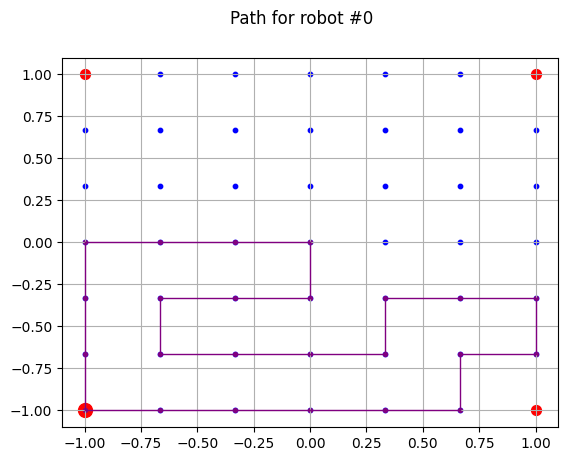

Robot #1
-------
Staring position: [0 6] -> [-1.0, 1.0]
(0, 6) -> (1, 6) -> (2, 6) -> (3, 6) -> (4, 6) -> (5, 6) -> (5, 5) -> (6, 5) -> (6, 4) -> (6, 3) -> (5, 3) -> (4, 3) -> (5, 4) -> (4, 4) -> (4, 5) -> (3, 5) -> (3, 4) -> (2, 4) -> (2, 5) -> (1, 5) -> (1, 4) -> (0, 4) -> (0, 5) -> (0, 6)

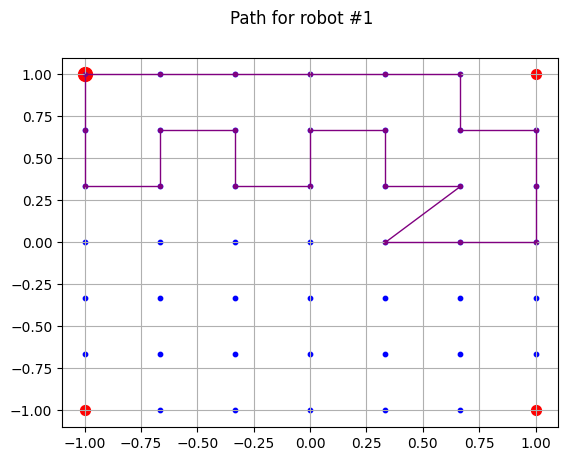

In [12]:
# visualize_paths_brute_force()
visualize_paths_faster()
